# From Aggregate Behavior to Rare Events: Numerical Experiments

This notebook accompanies Section~\ref{sec:CLT} of the book.

It illustrates numerically the main limit regimes discussed there:
- Central Limit Theorem (CLT) for sums of i.i.d.\ random variables,
- Large deviations (rare averages),
- Breakdown of CLT under heavy tails,
- Poisson limit for rare events,
- Extreme-value behavior for maxima.

All figures are saved into the `figs/` directory so that they can be
included directly into the LaTeX source of the chapter.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# Ensure figs/ directory exists
os.makedirs("figs", exist_ok=True)

rng = np.random.default_rng(12345)

def standard_normal_pdf(x):
    return (1.0 / np.sqrt(2.0 * np.pi)) * np.exp(-0.5 * x**2)

def poisson_pmf(k, lam):
    # Simple Poisson PMF for small lam and k
    return np.exp(-lam) * lam**k / math.factorial(k)

## 1. Central Limit Theorem (CLT) for Non-Gaussian Inputs

We first verify numerically that normalized sums of i.i.d.\ random
variables with finite variance tend toward a Gaussian distribution.

We consider two non-Gaussian examples:
- Uniform distribution on $[0,1]$,
- Exponential distribution with mean $1$.

For each case, we plot histograms of the normalized sums
\[
    Z_N = \frac{S_N - N\mu}{\sqrt{N\sigma^2}},
\]
for several values of $N$, and overlay the standard normal density.

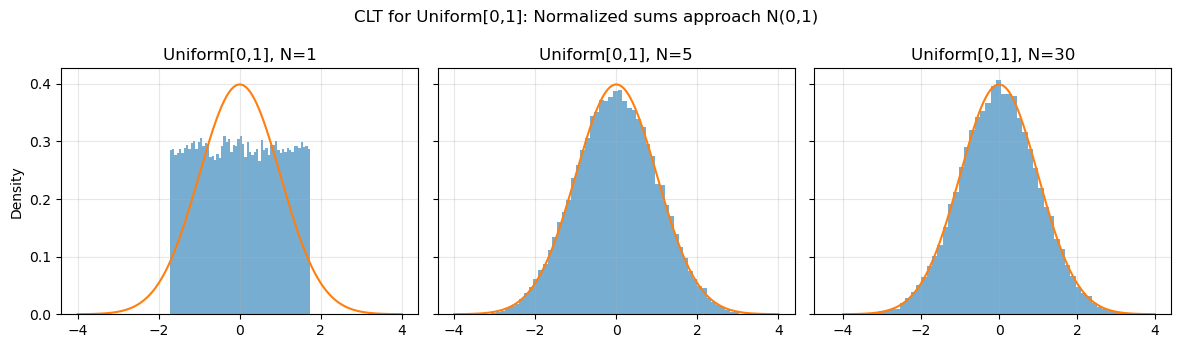

In [2]:
# CLT for Uniform[0,1]
mu_U = 0.5
sigma2_U = 1.0 / 12.0
sigma_U = np.sqrt(sigma2_U)

Ns = [1, 5, 30]
num_samples = 50000
x_plot = np.linspace(-4, 4, 400)
pdf_plot = standard_normal_pdf(x_plot)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
for ax, N in zip(axes, Ns):
    X = rng.uniform(0.0, 1.0, size=(num_samples, N))
    S_N = X.sum(axis=1)
    Z_N = (S_N - N * mu_U) / (np.sqrt(N) * sigma_U)

    ax.hist(Z_N, bins=60, density=True, alpha=0.6)
    ax.plot(x_plot, pdf_plot)
    ax.set_title(f"Uniform[0,1], N={N}")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Density")
fig.suptitle("CLT for Uniform[0,1]: Normalized sums approach N(0,1)")
plt.tight_layout()
fig.savefig("figs/clt_uniform_panels.png", dpi=150)
plt.show()

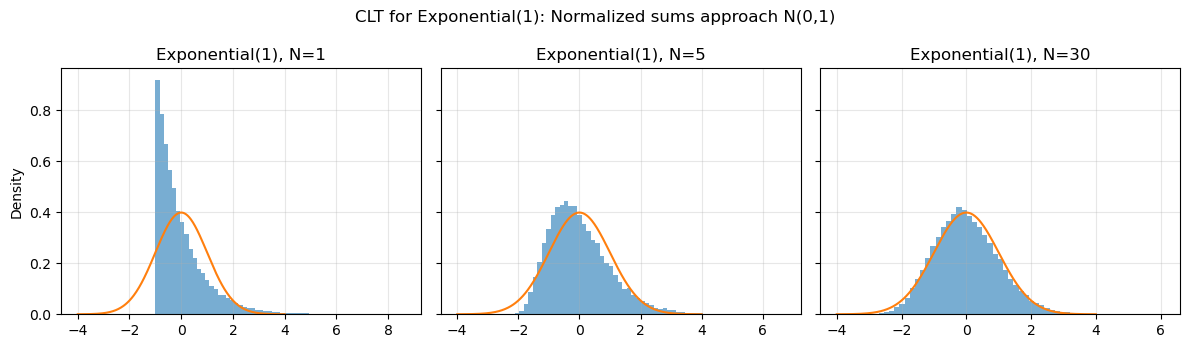

In [3]:
# CLT for Exponential(1)
mu_E = 1.0
sigma2_E = 1.0
sigma_E = 1.0

Ns = [1, 5, 30]
num_samples = 50000
x_plot = np.linspace(-4, 4, 400)
pdf_plot = standard_normal_pdf(x_plot)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
for ax, N in zip(axes, Ns):
    X = rng.exponential(scale=1.0, size=(num_samples, N))
    S_N = X.sum(axis=1)
    Z_N = (S_N - N * mu_E) / (np.sqrt(N) * sigma_E)

    ax.hist(Z_N, bins=60, density=True, alpha=0.6)
    ax.plot(x_plot, pdf_plot)
    ax.set_title(f"Exponential(1), N={N}")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Density")
fig.suptitle("CLT for Exponential(1): Normalized sums approach N(0,1)")
plt.tight_layout()
fig.savefig("figs/clt_exponential_panels.png", dpi=150)
plt.show()

## 2. Large Deviations: Rare Averages

The CLT describes typical fluctuations of order $\sqrt{N}$ around the mean.
Large deviation theory, by contrast, quantifies the exponentially small
probabilities of \emph{atypical} averages.

Here we illustrate empirically the decay of
\[
    \mathbb{P}\Bigl( \tfrac{1}{N}\sum_{i=1}^N X_i \ge x \Bigr)
\]
for a Bernoulli$(1/2)$ model and a fixed threshold $x=0.7$.

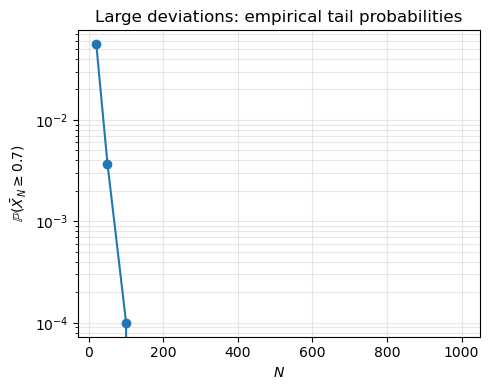

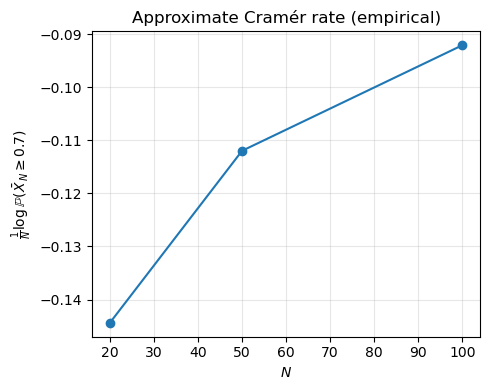

In [4]:
# Large deviations for Bernoulli(1/2)
p = 0.5
x_threshold = 0.7
Ns_ld = [20, 50, 100, 200, 500, 1000]
num_trials = 20000

probs = []
for N in Ns_ld:
    X = rng.binomial(1, p, size=(num_trials, N))
    averages = X.mean(axis=1)
    prob_est = np.mean(averages >= x_threshold)
    probs.append(prob_est)

fig, ax = plt.subplots(figsize=(5, 4))
ax.semilogy(Ns_ld, probs, marker="o")
ax.set_xlabel("$N$")
ax.set_ylabel(r"$\mathbb{P}(\bar X_N \geq 0.7)$")
ax.set_title("Large deviations: empirical tail probabilities")
ax.grid(alpha=0.3, which="both")
plt.tight_layout()
fig.savefig("figs/large_deviations_bernoulli.png", dpi=150)
plt.show()

# Plot log probability divided by N to highlight approximate linear decay
fig, ax = plt.subplots(figsize=(5, 4))
vals = np.array(probs)
mask = vals > 0
ax.plot(np.array(Ns_ld)[mask], np.log(vals[mask]) / np.array(Ns_ld)[mask], marker="o")
ax.set_xlabel("$N$")
ax.set_ylabel(r"$\frac{1}{N}\log \mathbb{P}(\bar X_N \geq 0.7)$")
ax.set_title("Approximate Cramér rate (empirical)")
ax.grid(alpha=0.3)
plt.tight_layout()
fig.savefig("figs/large_deviations_bernoulli_rate.png", dpi=150)
plt.show()

## 3. Breakdown of CLT Under Heavy Tails

We now study a family of symmetric heavy-tailed distributions with
power-law tails
\[
    p(x) \propto (1+|x|)^{-(\alpha+1)}.
\]
For $\alpha \le 2$, the variance diverges, and the usual CLT (with
$\sqrt{N}$ scaling) fails.

We simulate normalized sums for different tail exponents
$\alpha \in \{1.5, 2.5, 3.5\}$ and compare their histograms.  For
$\alpha > 2$, the CLT predicts approximate Gaussian behavior; for
$\alpha \le 2$, strong non-Gaussian features persist even at large $N$.

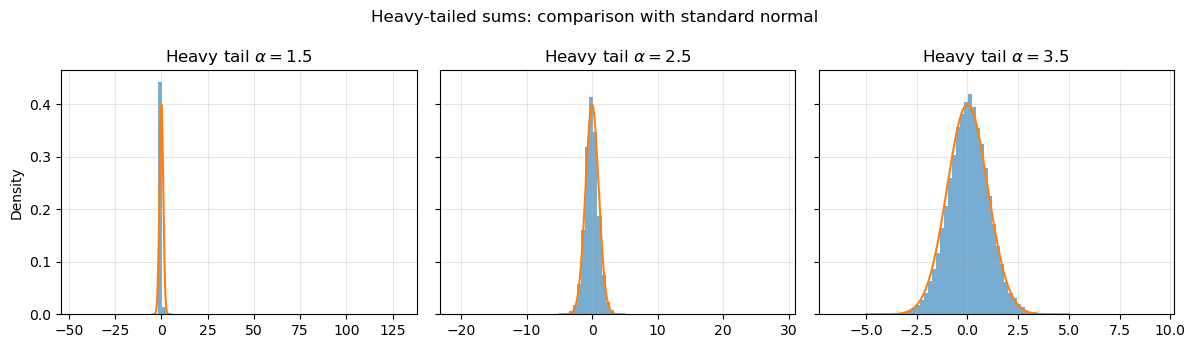

In [5]:
def sample_symmetric_pareto(alpha, size, rng=rng):
    # Sample from a symmetric Pareto-like distribution with tail exponent alpha.
    Y = rng.pareto(alpha, size=size)  # heavy tail on [0, +inf)
    signs = rng.integers(0, 2, size=size)
    signs = 2 * signs - 1  # 0,1 -> -1,+1
    return signs * Y

alphas = [1.5, 2.5, 3.5]
N_ht = 500  # number of summands
num_samples_ht = 50000

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
x_plot = np.linspace(-5, 5, 400)
pdf_plot = standard_normal_pdf(x_plot)

for ax, alpha in zip(axes, alphas):
    X = sample_symmetric_pareto(alpha, size=(num_samples_ht, N_ht))
    # Empirical mean and variance for normalization (when they exist)
    X_flat = X[:, 0]
    m_hat = np.mean(X_flat)
    v_hat = np.var(X_flat)

    if v_hat > 0:
        Z = (X.sum(axis=1) - N_ht * m_hat) / np.sqrt(N_ht * v_hat)
    else:
        Z = X.sum(axis=1)

    ax.hist(Z, bins=80, density=True, alpha=0.6)
    ax.plot(x_plot, pdf_plot)
    ax.set_title(rf"Heavy tail $\alpha={alpha}$")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Density")
fig.suptitle("Heavy-tailed sums: comparison with standard normal")
plt.tight_layout()
fig.savefig("figs/heavytail_sums_histograms.png", dpi=150)
plt.show()

## 4. Poisson Limit for Rare Events

Here we illustrate the Poisson limit theorem: if we have
many Bernoulli trials with small success probability
$\rho = \lambda/N$ and fixed $\lambda$, then
\[
    S_N = \sum_{i=1}^N X_i
\]
is approximately Poisson$(\lambda)$.

We fix $\lambda=5$ and compare Binomial$(N,\lambda/N)$ samples to
the Poisson$(5)$ distribution for increasing $N$.

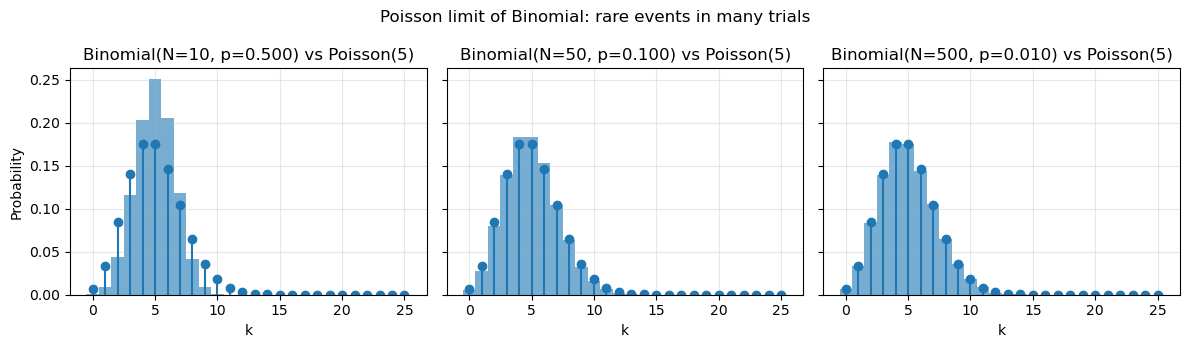

In [6]:
lam = 5.0
Ns_pois = [10, 50, 500]
num_samples_pois = 50000

max_k = 25  # range of k values for plotting pmfs

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
k_vals = np.arange(0, max_k + 1)
pois_pmf_vals = np.array([poisson_pmf(k, lam) for k in k_vals])

for ax, N in zip(axes, Ns_pois):
    rho = lam / N
    S = rng.binomial(N, rho, size=num_samples_pois)
    ax.hist(S, bins=np.arange(-0.5, max_k + 1.5, 1.0), density=True, alpha=0.6)
    ax.stem(k_vals, pois_pmf_vals, basefmt=" ")
    ax.set_title(f"Binomial(N={N}, p={rho:.3f}) vs Poisson(5)")
    ax.set_xlabel("k")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Probability")
fig.suptitle("Poisson limit of Binomial: rare events in many trials")
plt.tight_layout()
fig.savefig("figs/poisson_limit_binomial.png", dpi=150)
plt.show()

## 5. Extreme Values: Maxima and Rescaling

Finally, we explore maxima
\[
    M_N = \max\{X_1,\dots,X_N\}
\]
in three different cases:
- Uniform$[0,1]$ (bounded support),
- Exponential$(1)$ (light-tailed),
- Pareto (heavy-tailed).

We rescale $M_N$ in simple ways to hint at the three classical universality
classes (Weibull, Gumbel, Fréchet), without proving any theorems:
- Uniform: plot $N(1-M_N)$,
- Exponential: plot $M_N - \log N$,
- Pareto: plot $M_N / N^{1/\alpha}$ for a tail exponent $\alpha$.

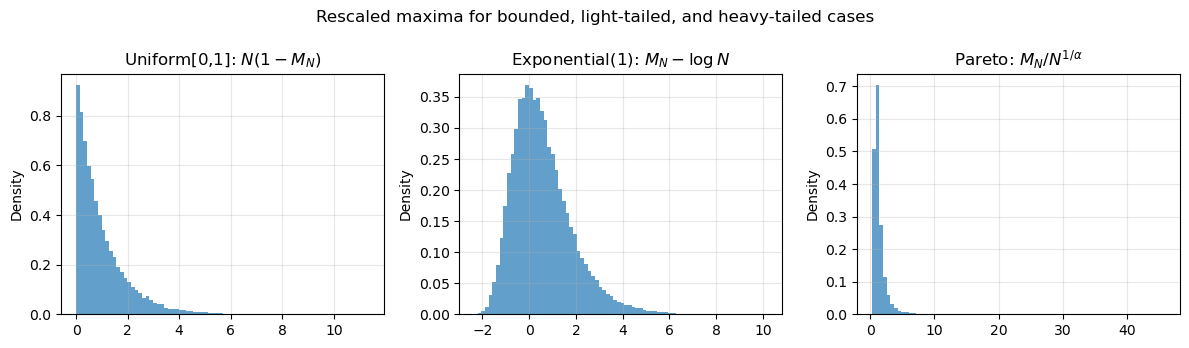

In [7]:
num_blocks = 50000
N_ext = 1000  # block size for maxima

# 1) Uniform[0,1]
X_uni = rng.uniform(0.0, 1.0, size=(num_blocks, N_ext))
M_uni = X_uni.max(axis=1)
Y_uni = N_ext * (1.0 - M_uni)

# 2) Exponential(1)
X_exp = rng.exponential(scale=1.0, size=(num_blocks, N_ext))
M_exp = X_exp.max(axis=1)
Y_exp = M_exp - np.log(N_ext)

# 3) Pareto heavy-tail with alpha=2.5
alpha_ext = 2.5
X_par = rng.pareto(alpha_ext, size=(num_blocks, N_ext))
M_par = X_par.max(axis=1)
Y_par = M_par / (N_ext ** (1.0 / alpha_ext))

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
axes[0].hist(Y_uni, bins=80, density=True, alpha=0.7)
axes[0].set_title(r"Uniform[0,1]: $N(1-M_N)$")
axes[0].grid(alpha=0.3)

axes[1].hist(Y_exp, bins=80, density=True, alpha=0.7)
axes[1].set_title(r"Exponential(1): $M_N - \log N$")
axes[1].grid(alpha=0.3)

axes[2].hist(Y_par, bins=80, density=True, alpha=0.7)
axes[2].set_title(r"Pareto: $M_N / N^{1/\alpha}$")
axes[2].grid(alpha=0.3)

for ax in axes:
    ax.set_ylabel("Density")

fig.suptitle("Rescaled maxima for bounded, light-tailed, and heavy-tailed cases")
plt.tight_layout()
fig.savefig("figs/extreme_values_rescaled.png", dpi=150)
plt.show()

## 6. Summary

In this notebook we:

- Verified the Central Limit Theorem empirically for non-Gaussian inputs
  (uniform and exponential),
- Observed exponential decay of rare averages (large deviations),
- Demonstrated the breakdown of Gaussian behavior under heavy tails,
- Illustrated the Poisson limit for rare-event counts,
- Explored rescaled maxima in bounded, light-tailed, and heavy-tailed settings.

These experiments complement the theoretical discussion of
Section~\ref{sec:CLT} and provide ready-to-use figures for the examples
and exercises in the chapter.